# Weekly Departmental Sales prediction using SARIMA model

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Weekly Sales data of Store 2, Department 12. Total Store = , Total Department = 

In [32]:
data = pd.read_csv(r"C:\Users\abhi2\Desktop\TSA_Data_Final.csv")
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,2,12,05-02-2010,6906.20,False
1,2,12,12-02-2010,6507.63,True
2,2,12,19-02-2010,6786.66,False
3,2,12,26-02-2010,7281.54,False
4,2,12,05-03-2010,8806.59,False


In [33]:
data = data[["Date", "Weekly_Sales", "IsHoliday"]]
data

,Date,Weekly_Sales,IsHoliday
0,05-02-2010,6906.20,False
1,12-02-2010,6507.63,True
2,19-02-2010,6786.66,False
3,26-02-2010,7281.54,False
4,05-03-2010,8806.59,False
...,...,...,...
138,28-09-2012,8029.62,False
139,05-10-2012,7107.15,False
140,12-10-2012,7161.14,False
141,19-10-2012,8206.99,False


In [34]:
#data['IsHoliday'] = data['IsHoliday'].astype(int)

In [35]:
data .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
 2   IsHoliday     143 non-null    bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 2.5+ KB


In [36]:
data.groupby("IsHoliday")["Weekly_Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
IsHoliday,,,,,,,,
False,133.0,7810.698571,1108.300681,4709.72,7107.1500,7936.47,8567.8200,10480.81
True,10.0,6741.741000,1161.723697,5186.44,5923.1475,6649.55,7530.2875,8909.92


,Date,Weekly_Sales,IsHoliday
1,12-02-2010,6507.63,True
31,10-09-2010,8909.92,True
42,26-11-2010,7679.34,True
47,31-12-2010,5186.44,True
53,11-02-2011,5728.32,True
83,09-09-2011,7083.13,True
94,25-11-2011,6757.66,True
99,30-12-2011,5327.95,True
105,10-02-2012,6541.44,True
135,07-09-2012,7695.58,True


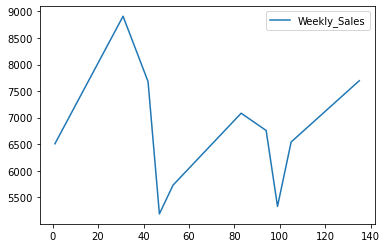

In [37]:
Holiday_Data = data.loc[(data["IsHoliday"] == True)]
Holiday_Data.describe()
Holiday_Data.plot()
Holiday_Data

<AxesSubplot:>

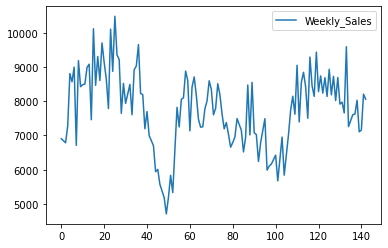

In [38]:
NA_Holiday_Data = data.loc[(data["IsHoliday"] == False)]
NA_Holiday_Data.describe()
NA_Holiday_Data.plot()

In [39]:
data["Date"] = pd.to_datetime(data["Date"], format= "%d-%m-%Y")
data = data.set_index("Date")

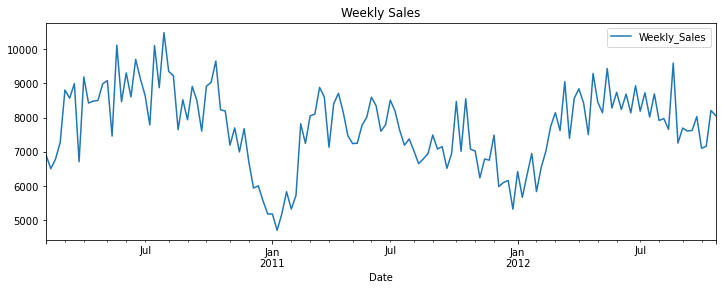

In [40]:
# PLotting of time series data
data.plot(figsize =(12,4))
plt.legend(loc="best")
plt.title("Weekly Sales")
plt.show(block = False)


In [41]:
#import matplotlib.pyplot as plt
# y = data["Weekly_Sales"]
#x = data["Date"]
#n = data["IsHoliday"]

#fig, ax = plt.subplots()
#plt.plot(x, y)

#for i, txt in enumerate(n):
#    ax.annotate(txt, (y[i], x[i]))


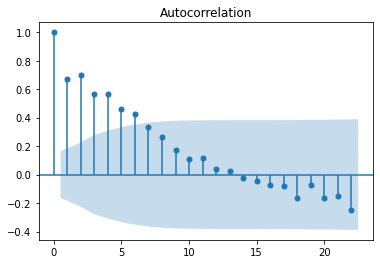

In [42]:
# Plotting ACF graph
plot_acf(data['Weekly_Sales']);

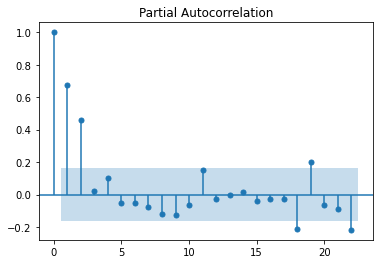

In [43]:
# Plotting PACF Graph
plot_pacf(data['Weekly_Sales']);

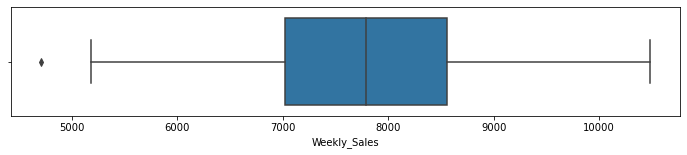

In [44]:
# Treating outliers
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = data["Weekly_Sales"],whis = 1.5)

### Histogram of Time Series Data

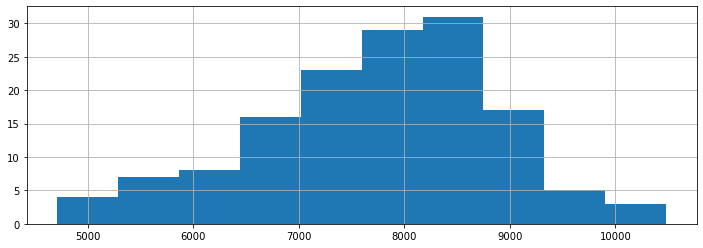

In [45]:
fig = data.Weekly_Sales.hist(figsize=(12,4))

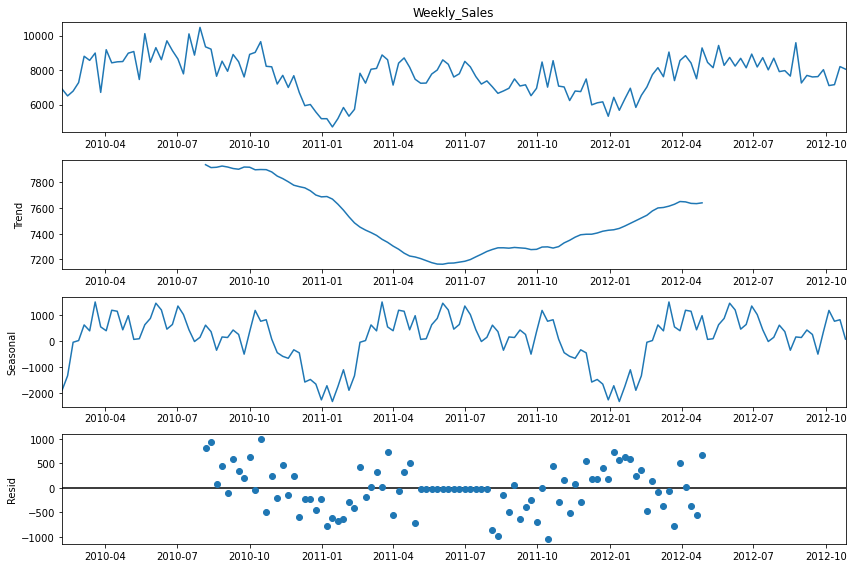

In [46]:
# Time Series Decomposition - Additive
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Weekly_Sales, model = "additive")
# seasonal variation is constant over time thus we use additive model
fig = decomposition.plot()
plt.show()

In [47]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data["Weekly_Sales"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
# p-value for adf test is less than 0.05, reject null, data is stationary

ADF Statistic: -2.981391303729758
p-value: 0.036669142407023736


In [48]:
# perform kpss to confirm stationarity
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Weekly_Sales'])

print('KPSS Statistics %f' % kpss_test[0])
print('Critical value @ 0.05: %0.2f' %kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

# kpss test results support adf results, proceeding with consideration that data is stationary

KPSS Statistics 0.140875
Critical value @ 0.05: 0.46
p-value: 0.100000


In [49]:
def optimize_SARIMA(parameters_list, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    df_length = len(data)
    train_len = round(0.80*df_length)
    data_train = data[0:train_len]
    data_test = data[train_len:]

    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0],0, param[1]), seasonal_order=(param[2],0, param[3], s)).fit()
        except:
            continue
            
        #aic = model.aic
        data_train['arima_model'] = model.fittedvalues
        #data_train['arima_model'][:4+1] = np.NaN
        train_mape = np.round(np.mean(np.abs(data_train['Weekly_Sales'] - data_train['arima_model']) / data_train['Weekly_Sales'])*100,2)
        
        #forecast on test
        forecast  = model.predict(start = train_len, end = data.shape[0] )
        test_mape = np.round(np.mean(np.abs(data_test['Weekly_Sales']-forecast)/data_test['Weekly_Sales'])*100,2)
        
        results.append([param, train_mape, test_mape])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'Train_MAPE', 'Test_MAPE']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='Test_MAPE', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
###### CODE TO COMPUTE MODEL PERFORMANCE FOR VARIOUS PARAMETER COMBINATIONS

p = range(2, 3, 1)
#d = 0
q = range(0, 6, 1)
P = range(2, 3, 1)
#D = 0
Q = range(0, 6, 1)
s = 52

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

36


result_df = optimize_SARIMA(parameters_list, 52, data['Weekly_Sales'])
result_df

result_df.to_csv('Model_Selection_MAPE_based_2.csv')

In [51]:
# Splitting the Data in Test and Training
df_length = len(data)
train_len = round(0.80*df_length)
data_train = data[0:train_len]
data_test = data[train_len:]

In [52]:
data_train.tail()

,Weekly_Sales,IsHoliday
Date,,
2012-03-09,7620.70,False
2012-03-16,9050.30,False
2012-03-23,7395.20,False
2012-03-30,8558.41,False
2012-04-06,8842.92,False


In [53]:
# Creating model for Training set  (fIT MODEL ON TRAIN)

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_train["Weekly_Sales"],
                                order=(2, 0, 5),
                                seasonal_order=(2, 0, 4, 52)).fit()
#output_df_train = ARIMA_MODEL.fit()

print(ARIMA_MODEL.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                  Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(2, 0, 5)x(2, 0, [1, 2, 3, 4], 52)   Log Likelihood                -918.780
Date:                                       Mon, 09 May 2022   AIC                           1865.560
Time:                                               21:51:44   BIC                           1903.867
Sample:                                           02-05-2010   HQIC                          1881.107
                                                - 04-06-2012                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0551     

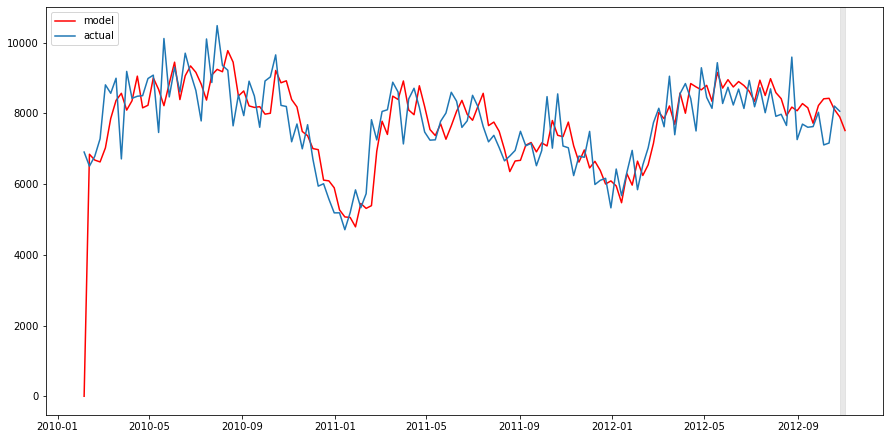

In [54]:
# FITTED VALS ON TRAINING DATA
data_train['arima_model'] = ARIMA_MODEL.fittedvalues
#data_train['arima_model'][:4+1] = np.NaN

# FORECASTING VALUES TO BE COMPARED WITH TEST DATA
forecast = ARIMA_MODEL.predict(start = train_len, end = data.shape[0] )
forecast = data_train['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['Weekly_Sales'], label='actual')
plt.legend()

plt.show()

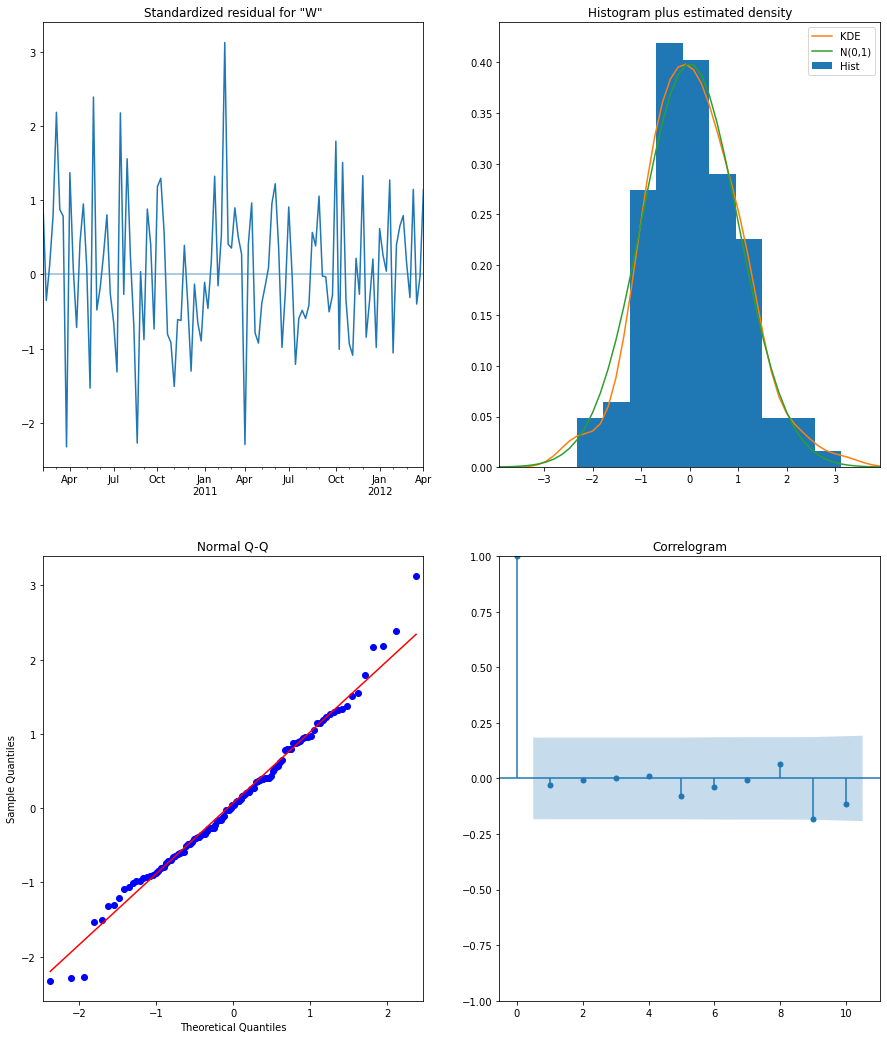

In [55]:
ARIMA_MODEL.plot_diagnostics(figsize=(15, 18))
plt.show()

In [56]:
# EVALUATE MAPE FOR TRAINING DATA
mape = np.round(np.mean(np.abs(data_train['Weekly_Sales']-data_train['arima_model'])/data_train['Weekly_Sales'])*100,2)
mape

8.51

In [57]:
# EVALUATE MAPE FOR TEST
mape = np.round(np.mean(np.abs(data_test['Weekly_Sales']-forecast[114:])/data_test['Weekly_Sales'])*100,2)
mape

6.22

In [58]:
#!pip install pmdarima

In [59]:
import pmdarima as pmd

In [60]:
pmd.auto_arima(data_train.Weekly_Sales, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=52)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=1844.464, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1868.299, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1837.335, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1842.711, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1866.342, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1835.925, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1837.393, Time=0.26 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1839.301, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1837.944, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1837.935, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1841.580, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=1840.229, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52]             : AIC=1834.137, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52]             : AIC=1835.497, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1

ARIMA(maxiter=5, order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)